Installing and import necessary libraries and packages

In [ ]:
!pip install kaggle

In [ ]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc

Fetching the disease dataset with the Kaggle API

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"leylaeminova","key":"1208531f4079d9b739761ed6f33dceb1"}


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
def fetch_disease_dataset(dataset_slug, destination_dir='./', unzip=True):

    os.environ['KAGGLE_USERNAME'] = 'leylaeminova'
    os.environ['KAGGLE_KEY'] = '1208531f4079d9b739761ed6f33dceb1'

    api = KaggleApi()
    api.authenticate()

    try:
        api.dataset_download_files(dataset_slug, path=destination_dir, unzip=unzip)

        files = os.listdir(destination_dir)

        return files

    except Exception as e:
        print(f"Error downloading dataset: {str(e)}")
        return []


dataset_slug = 'mansoordaku/ckdisease'
destination_directory = './disease_dataset'

downloaded_files = fetch_disease_dataset(dataset_slug, destination_directory)

if downloaded_files:
    print(f"Download successful. Files: {downloaded_files}")
else:
    print("Download failed.")


Download successful. Files: ['kidney_disease.csv']


Reading the dataset, checking its rows, datatypes and shape

In [ ]:
df = pd.read_csv('/content/disease_dataset/kidney_disease.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [ ]:
df.head(10)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
5,5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,...,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,...,36,NaN,NaN,no,no,no,good,no,no,ckd
7,7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,...,44,6900,5,no,yes,no,good,yes,no,ckd
8,8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,...,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


In [ ]:
df.shape

(400, 26)

#### Data Preprocessing & EDA

Identifying and handling missing values. Dropping identifier, unnecessary and highly imbalanced rows

In [ ]:
df.isna().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [ ]:
df['age'] = df['age'].fillna(df['age'].mean())
df.drop(['id', 'sg', 'su'], axis = 1, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              388 non-null    float64
 2   al              354 non-null    float64
 3   rbc             248 non-null    object 
 4   pc              335 non-null    object 
 5   pcc             396 non-null    object 
 6   ba              396 non-null    object 
 7   bgr             356 non-null    float64
 8   bu              381 non-null    float64
 9   sc              383 non-null    float64
 10  sod             313 non-null    float64
 11  pot             312 non-null    float64
 12  hemo            348 non-null    float64
 13  pcv             330 non-null    object 
 14  wc              295 non-null    object 
 15  rc              270 non-null    object 
 16  htn             398 non-null    object 
 17  dm              398 non-null    obj

In [ ]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x) #removing unnecessary tab chars

In [ ]:
def drop_columns_with_nulls(dataset, threshold=50):

    # Identify columns with more than the specified threshold of null values
    columns_to_drop = df.columns[df.isnull().sum() > threshold]

    # Drop the identified columns
    df_dropped = df.drop(columns=columns_to_drop)

    return df_dropped

In [ ]:
df = drop_columns_with_nulls(df)

In [ ]:
def fill_nulls_with_mode(dataset):

    df_filled = df.apply(lambda col: col.fillna(col.mode()[0]))

    return df_filled
df = fill_nulls_with_mode(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   al              400 non-null    float64
 3   pcc             400 non-null    object 
 4   ba              400 non-null    object 
 5   bgr             400 non-null    float64
 6   bu              400 non-null    float64
 7   sc              400 non-null    float64
 8   htn             400 non-null    object 
 9   dm              400 non-null    object 
 10  cad             400 non-null    object 
 11  appet           400 non-null    object 
 12  pe              400 non-null    object 
 13  ane             400 non-null    object 
 14  classification  400 non-null    object 
dtypes: float64(6), object(9)
memory usage: 47.0+ KB


Visualizing numeric and categorical features to see their distribution

In [ ]:
def visualize_numeric_features(dataset):
  plt.figure(figsize = (20, 15))
  plotnumber = 1
  num_cols = dataset.select_dtypes(include=['float64', 'int64'])
  for column in num_cols:
      if plotnumber <= 14:
          ax = plt.subplot(3, 5, plotnumber)
          sns.histplot(df[column], kde=True)
          plt.xlabel(column)

      plotnumber += 1

  plt.tight_layout()
  plt.show()

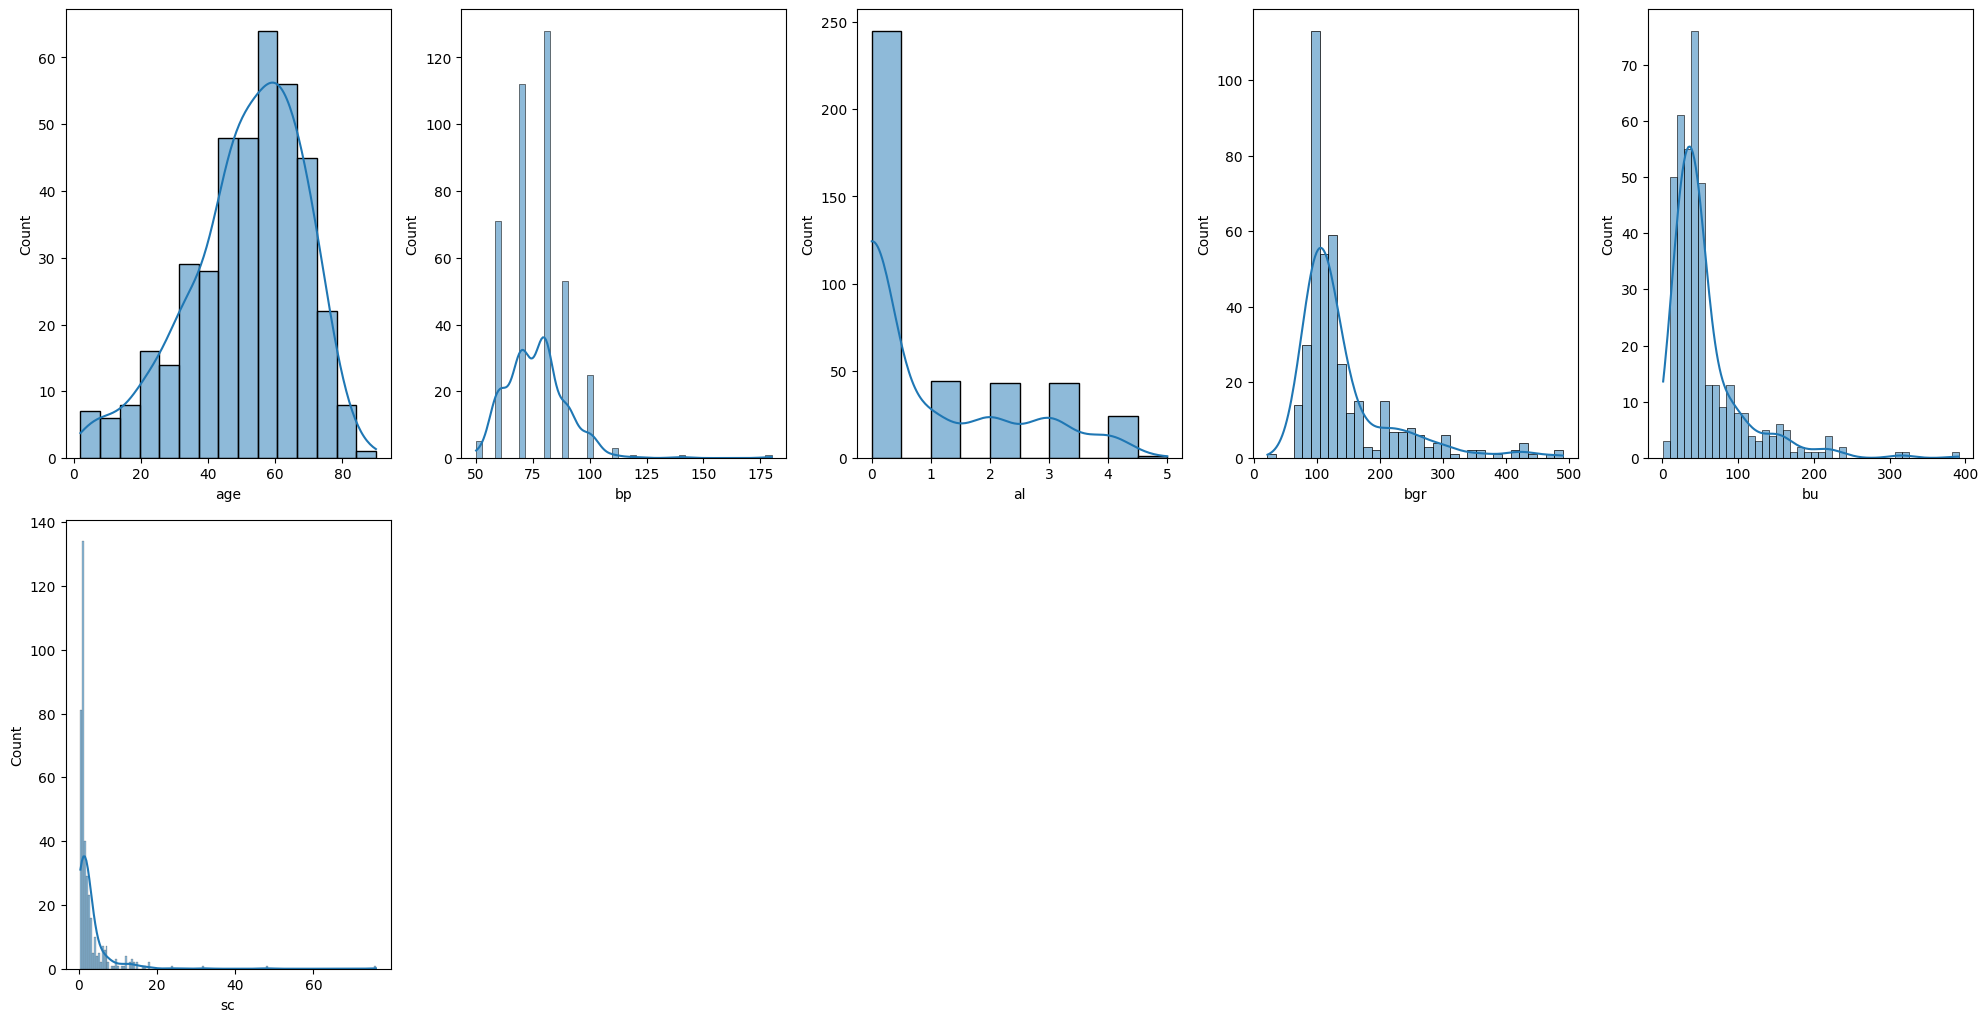

In [ ]:
visualize_numeric_features(df)

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

def visualize_cat_cols(dataset):
  fig, axes = plt.subplots(3, 3, figsize=(20, 5 * 3))

  for i, column in enumerate(cat_cols):
      ax = axes[i // 3, i % 3]
      sns.countplot(dataset, x = column, palette='rocket', ax=ax)
      ax.set_title(column)
      ax.set_xlabel(column)
      ax.set_ylabel('Count')


  plt.tight_layout()
  plt.show()

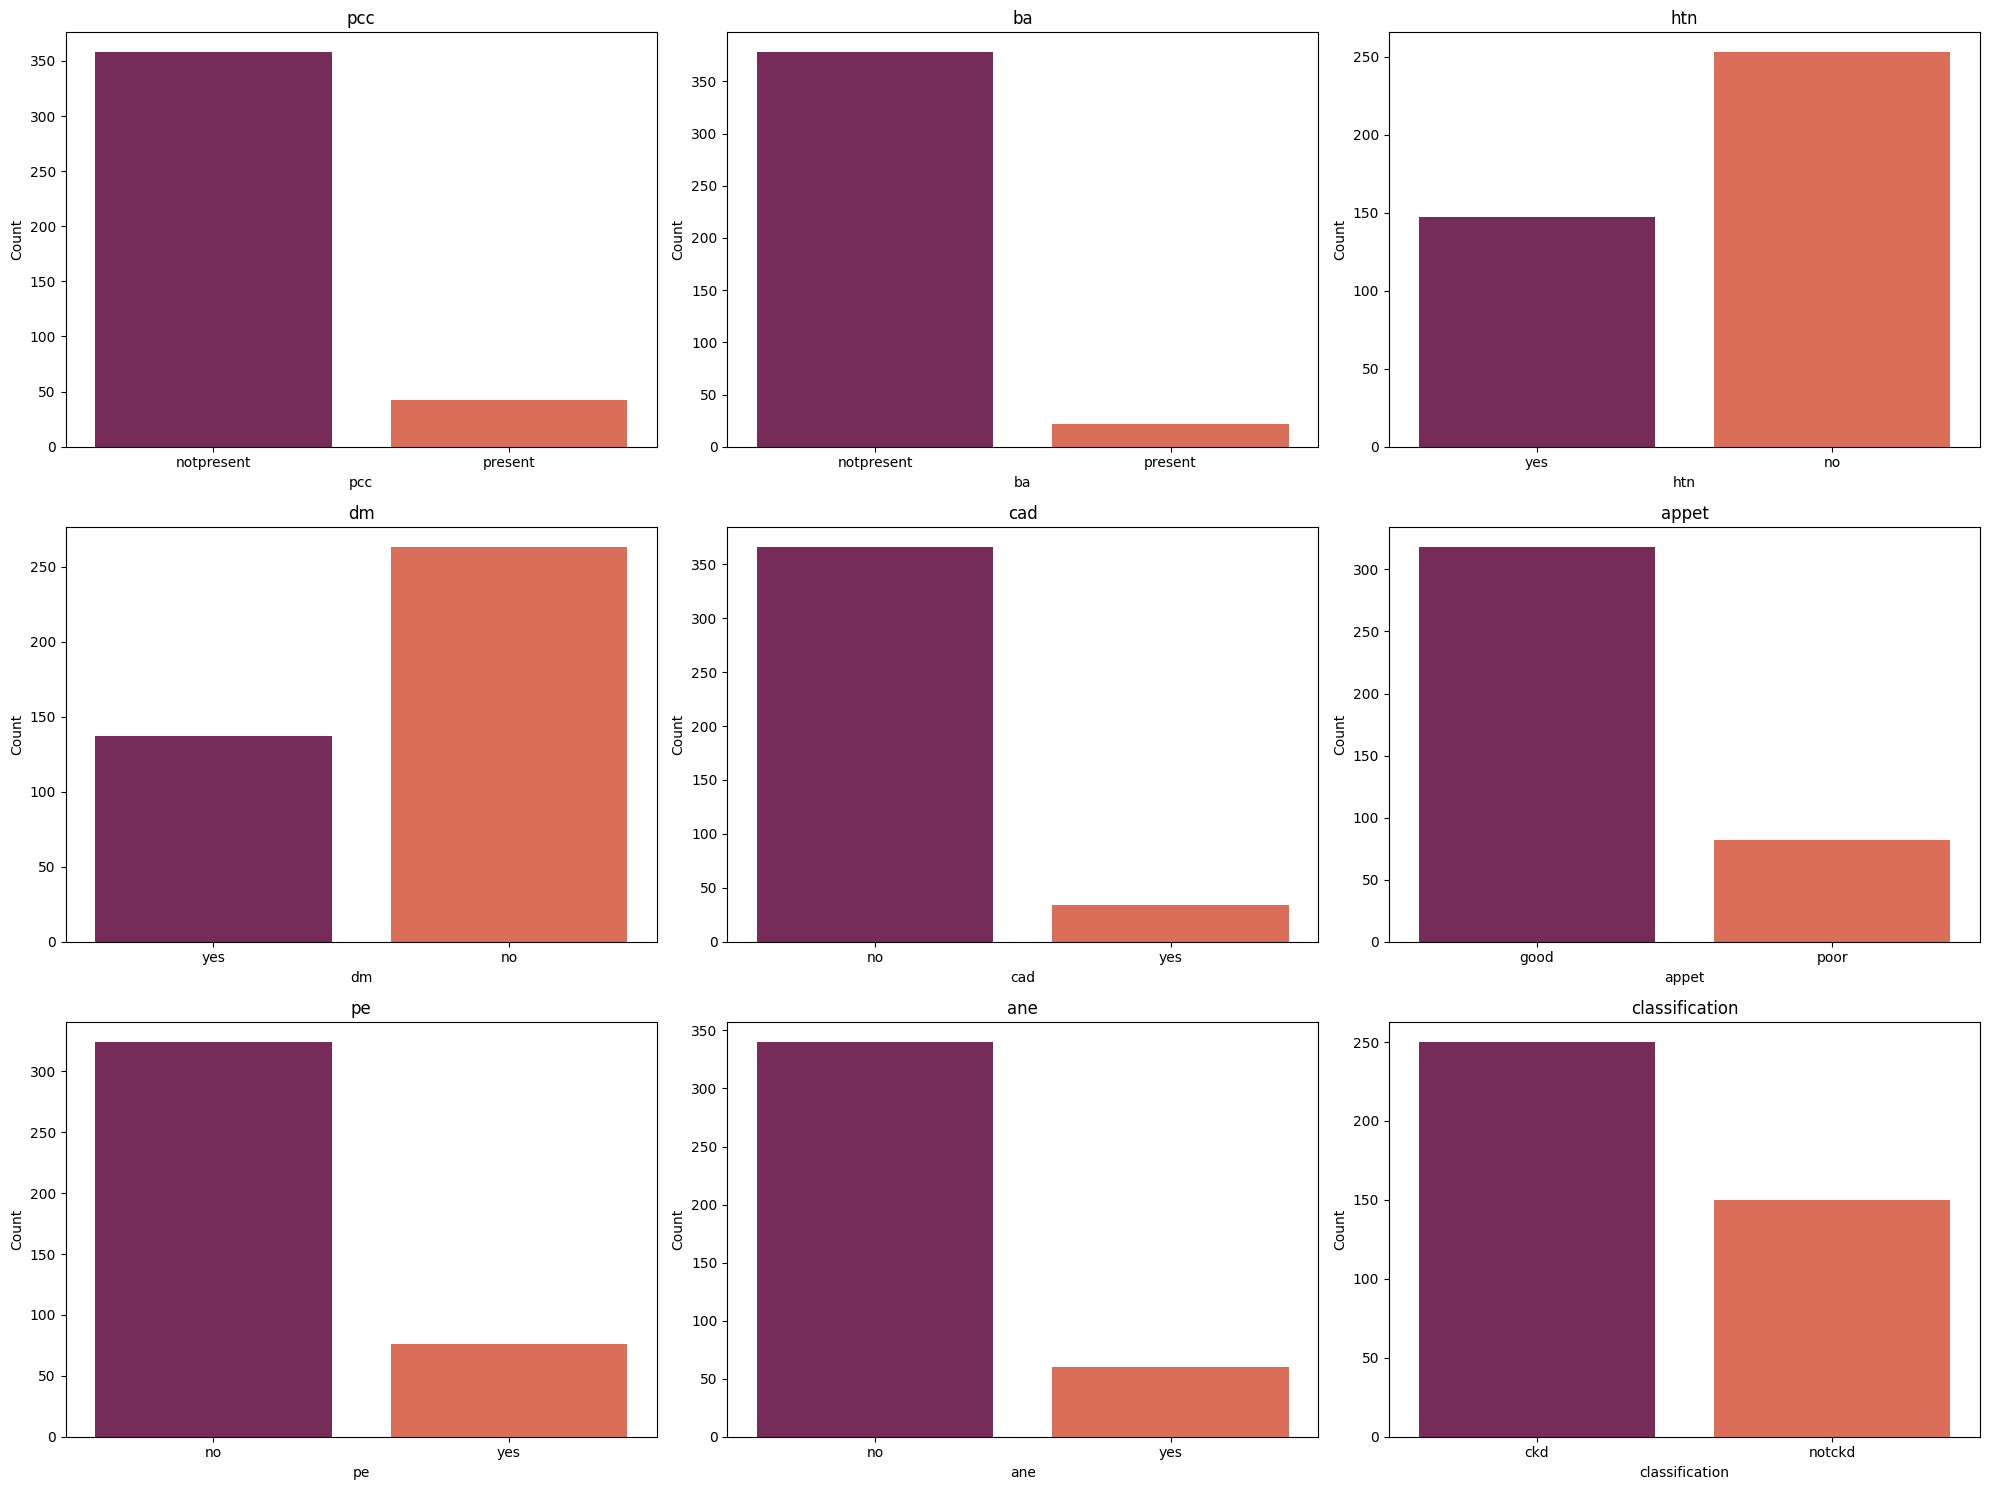

In [ ]:
visualize_cat_cols(df)

Checking outliers with the help of box plots

In [ ]:
num_cols = df.select_dtypes(include=['float64', 'int64'])
fig = px.box(df, y=num_cols.drop(['al', 'sc'], axis = 1).columns,
             title='Box Plots for detecting outliers',
             labels={'variable': 'Numerical Columns', 'value': 'Values'},
             template='plotly_white')
fig.show()

In [ ]:
num_cols = df.select_dtypes(include=['float64', 'int64'])
fig = px.box(df, y=num_cols.drop(['age', 'bp','bgr', 'bu'], axis = 1).columns,
             title='Box Plots for detecting outliers',
             labels={'variable': 'Numerical Columns', 'value': 'Values'},
             template='plotly_white')
fig.update_layout(yaxis=dict(range=[0, 10]))


In [ ]:
df.classification.value_counts()

ckd       250
notckd    150
Name: classification, dtype: int64

Checking dataset features' correlations with each other

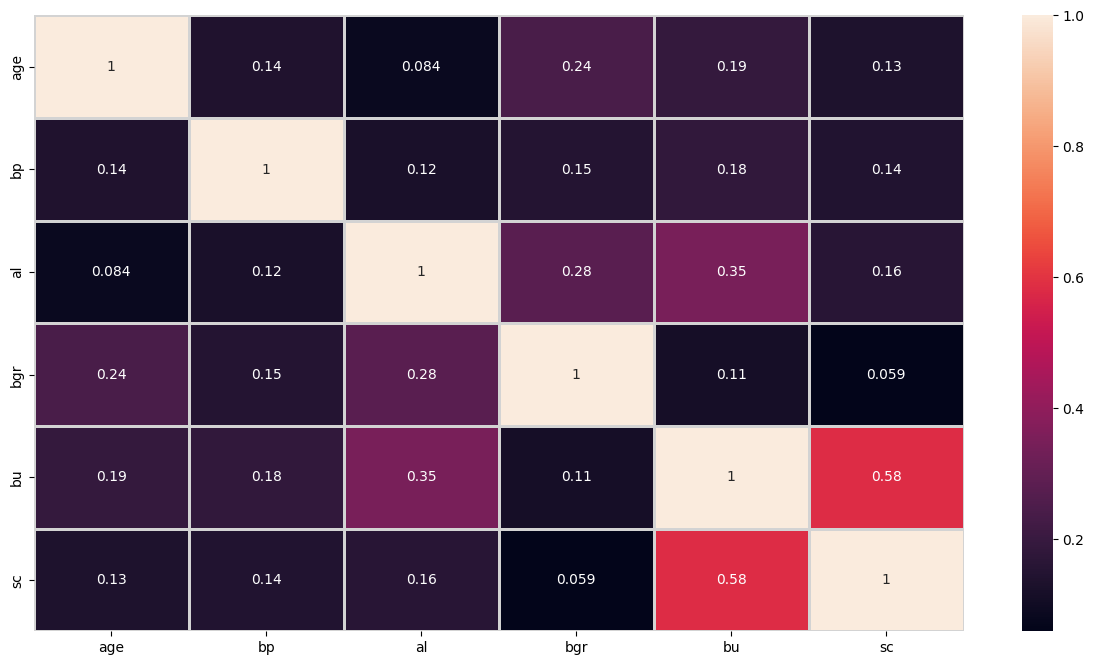

In [ ]:
plt.figure(figsize = (15, 8))

sns.heatmap(df.corr(numeric_only=True), annot = True, linewidths = 2, linecolor = 'lightgrey')
plt.show()

Plotting distribution of kidney disease according to age groups

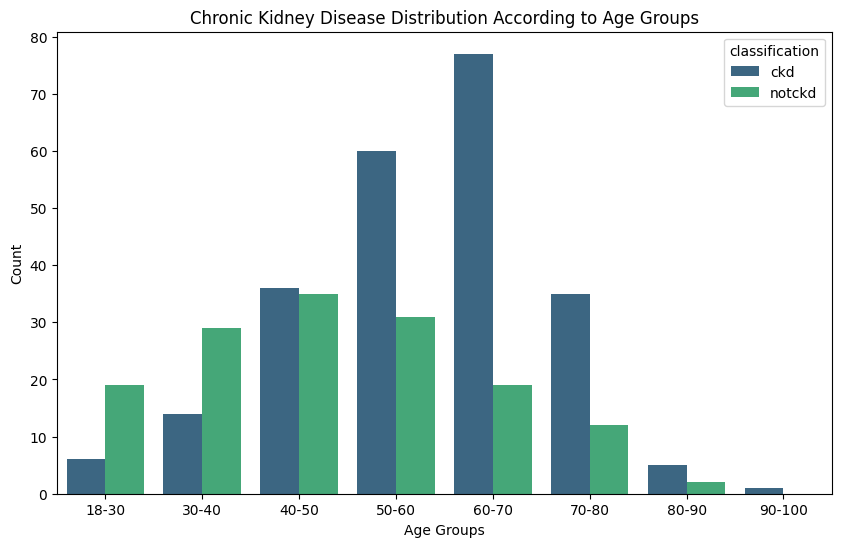

In [ ]:
age_bins = [18, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['18-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create a new column 'age_group' based on age bins
df_age = df.copy()
df_age['age_group'] = pd.cut(df_age['age'], bins=age_bins, labels=age_labels, right=False)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='classification', data=df_age, palette='viridis')
plt.title('Chronic Kidney Disease Distribution According to Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.show()

Plotting target column's distribution. There is an imbalance but it is not that horrifying

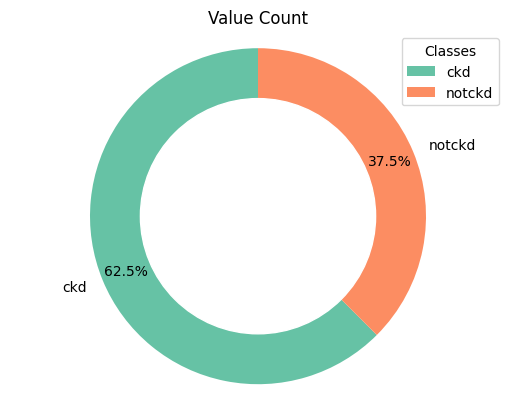

In [ ]:
value_counts = df['classification'].value_counts()
categories = value_counts.index
counts = value_counts.values


plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, pctdistance=0.85, colors=sns.color_palette('Set2'))

inner_circle = plt.Circle((0, 0), 0.7, color='white')
fig = plt.gcf()
fig.gca().add_artist(inner_circle)

plt.axis('equal')
plt.title('Value Count')

plt.legend(categories, title='Classes', loc='best')

Encoding categorical features and checking Label Encoder's mapping

In [ ]:
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
category_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(category_mapping)

{'ckd': 0, 'notckd': 1}


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   al              400 non-null    float64
 3   pcc             400 non-null    int64  
 4   ba              400 non-null    int64  
 5   bgr             400 non-null    float64
 6   bu              400 non-null    float64
 7   sc              400 non-null    float64
 8   htn             400 non-null    int64  
 9   dm              400 non-null    int64  
 10  cad             400 non-null    int64  
 11  appet           400 non-null    int64  
 12  pe              400 non-null    int64  
 13  ane             400 non-null    int64  
 14  classification  400 non-null    int64  
dtypes: float64(6), int64(9)
memory usage: 47.0 KB


#### Model training and evaluation

Splitting dataset to train and test sets

In [ ]:
X = df.drop('classification', axis=1)
y = df['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Random Forest Accuracy: 0.97
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        76
           1       0.92      1.00      0.96        44

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.96       120
weighted avg       0.97      0.97      0.97       120

Random Forest Confusion Matrix:
[[72  4]
 [ 0 44]]


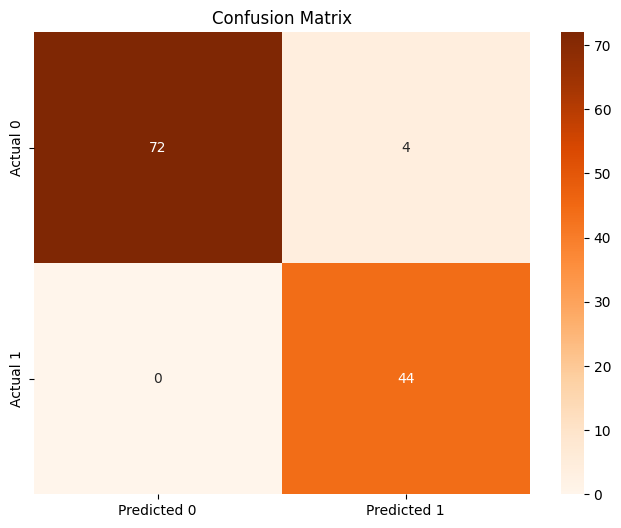

-------------------------------------------------------
Logistic Regression Accuracy: 0.94
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        76
           1       0.88      0.98      0.92        44

    accuracy                           0.94       120
   macro avg       0.93      0.95      0.94       120
weighted avg       0.95      0.94      0.94       120

Logistic Regression Confusion Matrix:
[[70  6]
 [ 1 43]]


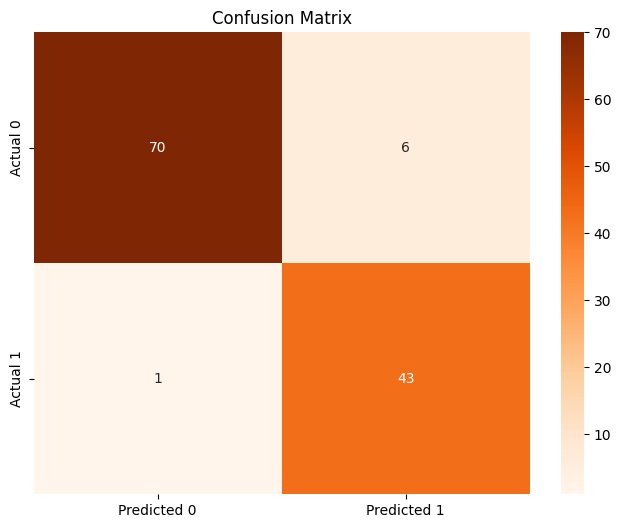

-------------------------------------------------------
CPU times: user 1.14 s, sys: 81.7 ms, total: 1.22 s
Wall time: 1.81 s


In [ ]:
%%time

models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=1000)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(f'{model_name} Confusion Matrix:')
    print(cm)
    cm1 = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Oranges', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.show()


    print('-' * 55)

In [ ]:
%%time
pipe_rf =  Pipeline([
    ("scaler", MinMaxScaler()),
    ("clf", RandomForestClassifier())
])
param_grid = {
    "clf__n_estimators": [100, 500, 1000],
    "clf__max_depth": [1, 5, 10, None],
    "clf__max_features": ["sqrt", "log2", None],
}

rf_gs = GridSearchCV(pipe_rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1000)
rf_gs.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
CPU times: user 1.67 s, sys: 336 ms, total: 2 s
Wall time: 1min 45s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [1, 5, 10, None],
                         'clf__max_features': ['sqrt', 'log2', None],
                         'clf__n_estimators': [100, 500, 1000]},
             verbose=1000)

In [ ]:
rf_gs.score(X_train, y_train)
y_pred_rf = rf_gs.predict(X_test)

In [ ]:
joblib.dump(rf_gs, "Random_Forest_model.joblib")

['Random_Forest_model.joblib']

In [ ]:
rf_gs.best_params_

{'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}

In [ ]:
def evaluate_model(y_pred, y_test):
  accuracy = accuracy_score(y_test, y_pred)
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  print(f"Model accuracy: {accuracy:.4f}")
  # print(classification_report)

In [ ]:
evaluate_model(y_pred_rf, y_test)

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        76
           1       0.90      1.00      0.95        44

    accuracy                           0.96       120
   macro avg       0.95      0.97      0.96       120
weighted avg       0.96      0.96      0.96       120

[[71  5]
 [ 0 44]]
Model accuracy: 0.9583


In [ ]:
%%time
pipe_lr =  Pipeline([
    ("scaler", StandardScaler()),
    ("logistic", LogisticRegression(solver='lbfgs', max_iter=1000))
])
param_grid_lr = {"logistic__C":np.logspace(-2,2,5)}

lr_gs = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=3, n_jobs=-1)
lr_gs.fit(X_train, y_train)


CPU times: user 63.6 ms, sys: 2.03 ms, total: 65.7 ms
Wall time: 228 ms


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [ ]:
joblib.dump(lr_gs, "Logistic_Regression_model.joblib")

['Logistic_Regression_model.joblib']

In [ ]:
y_pred_lr = lr_gs.predict(X_test)

In [ ]:
evaluate_model(y_pred_lr, y_test)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        76
           1       0.92      1.00      0.96        44

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.96       120
weighted avg       0.97      0.97      0.97       120

[[72  4]
 [ 0 44]]
Model accuracy: 0.9667


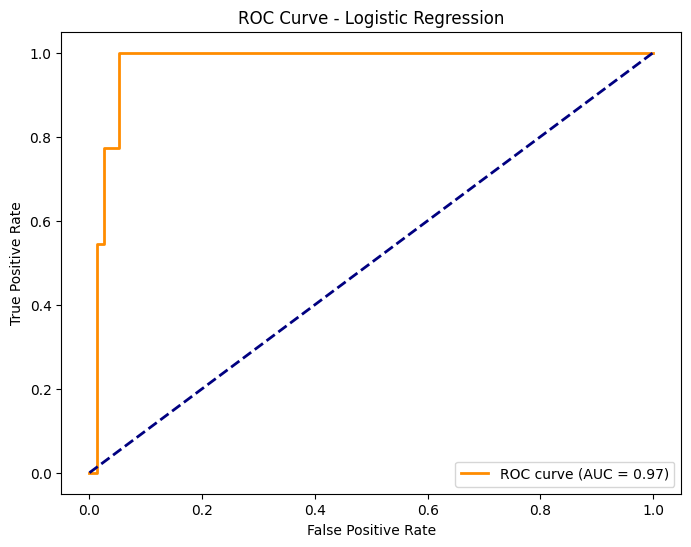

In [ ]:
fpr1, tpr1, _ = roc_curve(y_test, lr_gs.predict_proba(X_test)[:, 1])
roc_auc1 = auc(fpr1, tpr1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

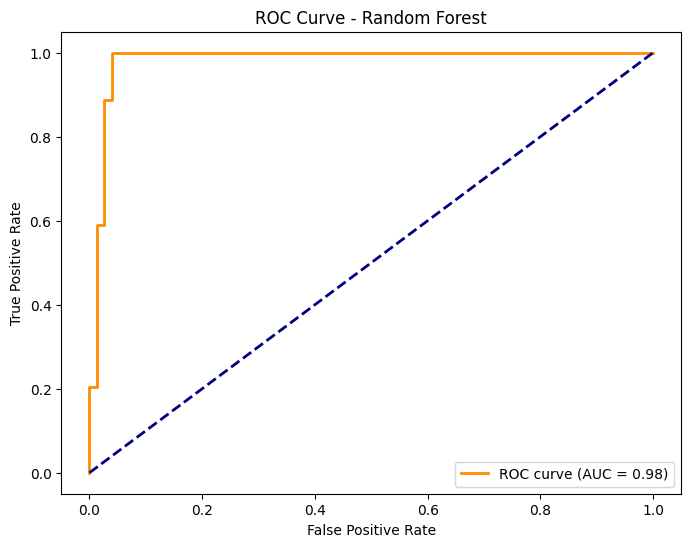

In [ ]:
fpr1, tpr1, _ = roc_curve(y_test, rf_gs.predict_proba(X_test)[:, 1])
roc_auc1 = auc(fpr1, tpr1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

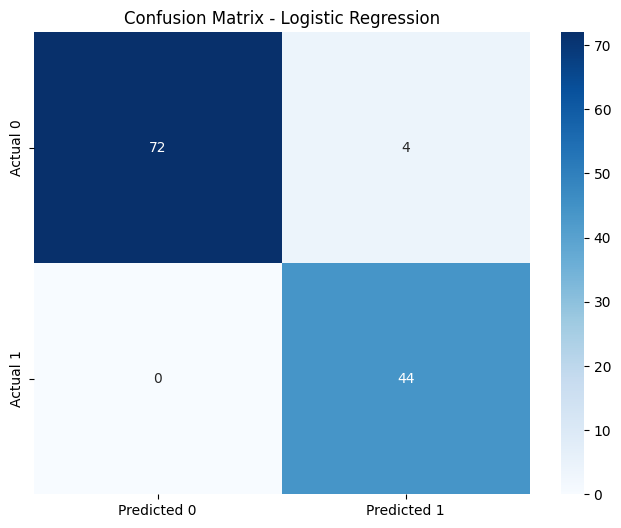

In [ ]:
cm1 = confusion_matrix(y_test, y_pred_lr)

ğplt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


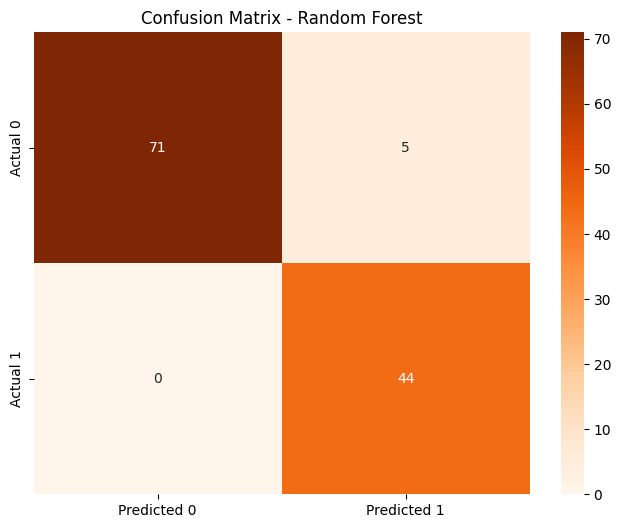

In [ ]:
cm1 = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Oranges', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Random Forest')
plt.show()


Getting user input for web

In [ ]:
def get_user_input(feature_names):
    features = []

    for feature_name in feature_names:
        while True:
            try:
                value = float(input(f'Enter value for {feature_name}: '))
                break
            except ValueError:
                print('Invalid input. Please enter a numeric value.')

        features.append(value)

    return np.array(features).reshape(1, -1)



def make_prediction(model_filename, user_input):
    model = joblib.load(model_filename)
    prediction = model.predict(user_input)[0]
    proba = model.predict_proba(user_input).max()
    return prediction, proba

def main():
    features = ['age','blood pressure', 'albumin',
                 'pus cellc cumps', 'bacteria', 'blood glucose rand',
                'blood urea','serum creatinine', 'hypertension', 'diabetes mellitus',
                'caronory artery disease', 'appetite', 'pedal edema','anemia' ]

    user_input = get_user_input(features)
    prediction, proba = make_prediction("Logistic_Regression_model.joblib", user_input)
    print(f"Your test result is {'positive' if prediction == 0 else 'negative'}.")
    print(f"The certanity of prediction: {proba*100:.2f}%")

if __name__ == "__main__":
  main()
